In [137]:
from IPython.display import SVG
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import MolDrawing, DrawingOptions

In [138]:
reverse_substitutions = {
    "[NO2]": "[N+](=O)[O-]",
    "[O2N]": "[N+](=O)[O-]",
    "[CHO]": "[CH1](=O)",
    "[OHC]": "[CH1](=O)",
    "[CO2Et]": "[C](=O)OCC",
    "[COOEt]": "[C](=O)OCC",
    "[OAc]": "[O]C(=O)C",
    "[NHAc]": "[NH]C(=O)C",
    "[Ac]": "[C](=O)C",
    "[OBz]": "[O]C(=O)c1ccccc1",
    "[Bz]": "[C](=O)c1ccccc1",
    "[OBn]": "[O]Cc1ccccc1",
    "[Bn]": "[CH2]c1ccccc1",
    "[NHBoc]": "[NH1]C(=O)OC(C)(C)C",
    "[NBoc]": "[NH1]C(=O)OC(C)(C)C",
    "[Boc]": "[C](=O)OC(C)(C)C",
    "[Cbm]": "[C](=O)N",
    "[Cbz]": "[C](=O)OCc1ccccc1",       # ??
    "[Cy]": "[CH1]1CCCCC1",
    "[Fmoc]": "[C](=O)OCC1c(cccc2)c2c3c1cccc3",
    "[Mes]": "[c]1c(C)cc(C)cc(C)1",
    "[OMs]": "[O]S(=O)(=O)C",
    "[Ms]": "[S](=O)(=O)C",
    "[Ph]": "[c]1ccccc1",
    "[Py]": "[c]1ncccc1",
    "[Suc]": "[C](=O)CCC(=O)O",
    "[TBS]": "[Si](C)(C)C(C)(C)C",
    "[TBZ]": "[C](=S)c1ccccc1",
    "[OTf]": "[O]S(=O)(=O)C(F)(F)F",
    "[Tf]": "[S](=O)(=O)C(F)(F)F",
    "[TFA]": "[C](=O)C(F)(F)F",
    "[TMS]": "[Si](C)(C)C",
    "[Ts]": "[S](=O)(=O)c1ccc(C)cc1",
    "[OMe]": "[O]C",
    "[MeO]": "[O]C",
    "[SMe]": "[S]C",
    "[MeS]": "[S]C",
    "[NMe]": "[NH]C",
    "[MeN]": "[NH]C",
    "[Me]": "[CH3]",
    "[OEt]": "[O]CC",
    "[EtO]": "[O]CC",
    "[Et]": "[CH2]C",
    "[Pr]": "[CH2]CC",
    "[nPr]": "[CH2]CC",
    "[Bu]": "[CH2]CCC",
    "[nBu]": "[CH2]CCC",
    "[iPr]": "[CH1](C)C",
    "[iBu]": "[CH2]C(C)C",
    "[OiBu]": "[O]CC(C)C",
    "[OtBu]": "[O]C(C)(C)C",
    "[tBu]": "[C](C)(C)C",
    "[CF3]": "[C](F)(F)F",
    "[F3C]": "[C](F)(F)F",
    "[NCF3]": "[NH]C(F)(F)F",
    "[CCl3]": "[C](Cl)(Cl)Cl",
    "[CO2H]": "[C](=O)O",
    "[COOH]": "[C](=O)O",
    "[CN]": "[C]#N",
    "[OCH3]": "[O]C",
    "[SO3H]": "[S](=O)(=O)O"
}

In [139]:
R_groups = ["[R]", "[R1]", "[R2]", "[R3]", "[R4]", "[R5]"]
placeholder_atoms = ["[Ne]", "[Ar]", "[Kr]", "[Xe]", "[Rn]", "[Nd]", "[Yb]", "[At]", "[Fm]", "[Er]"]

{'[Ne]': '[Et]', '[Ar]': '[iBu]'}


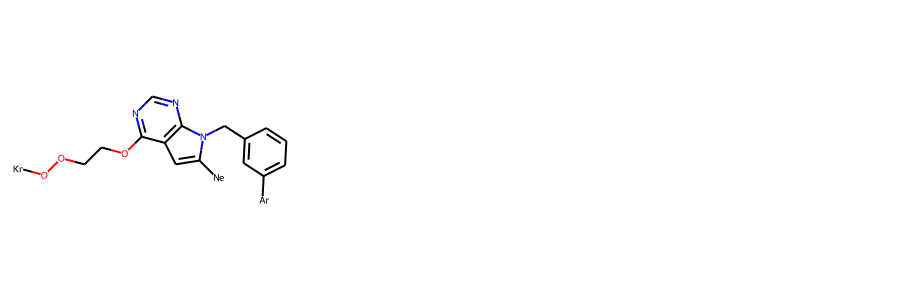

In [140]:
extracted_smi = "[R1]OOCCOC1=NC=NC2=C1C=C([Et])N2CC1C=C([iBu])C=CC=1"
sub_smi = extracted_smi

i = 0
mappings = {}
for k, v in reverse_substitutions.items():
    while k in sub_smi:
        placeholder_atom = placeholder_atoms[i]           # using random element as a placeholder to validify SMILES
        sub_smi = sub_smi.replace(k, placeholder_atom, 1)
        mappings[placeholder_atom] = k
        i += 1

for r in R_groups:
    placeholder_atom = placeholder_atoms[i]
    sub_smi = sub_smi.replace(r, placeholder_atom)        # no mapping needed for R groups

m = Chem.MolFromSmiles(sub_smi)
img = Draw.MolsToGridImage([m], subImgSize=(300, 300))
print(mappings)
display(img)

CCc1cc2c(OCCOO[Kr])ncnc2n1Cc1cccc(CC(C)C)c1


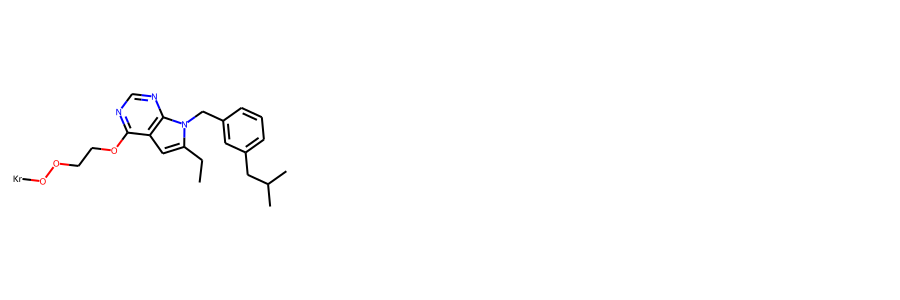

In [141]:
mw = Chem.RWMol(m)     # convert to editable molecule

for placeholder_atom, node in mappings.items():
    for i, atom in enumerate(mw.GetAtoms()):
        symbol = f"[{atom.GetSymbol()}]"
        if symbol == placeholder_atom:
            bond = atom.GetBonds()[0]                      # assuming R is singly bonded to the other atom
            adjacent_idx = bond.GetOtherAtomIdx(i)         # getting the idx of the other atom
            mw.RemoveAtom(i)

            adjacent_atom = mw.GetAtomWithIdx(adjacent_idx)
            adjacent_atom.SetNumRadicalElectrons(1)

            sub_smi = mappings[symbol]
            mR = Chem.MolFromSmiles(reverse_substitutions[sub_smi])
            combo = Chem.CombineMols(mw, mR)               # combine two subgraphs into a single graph

            bonding_atoms = []
            for j, new_atom in enumerate(combo.GetAtoms()):
                if new_atom.GetNumRadicalElectrons() == 1:
                    new_atom.SetNumRadicalElectrons(0)     # reset radical electrons
                    bonding_atoms.append(j)
            assert len(bonding_atoms) == 2, bonding_atoms

            mw = Chem.RWMol(combo)
            mw.AddBond(bonding_atoms[0], bonding_atoms[1], order=Chem.rdchem.BondType.SINGLE)
            break

img = Draw.MolsToGridImage([mw], subImgSize=(300,300))
print(Chem.MolToSmiles(mw))
display(img)